# Concentration vs Diameter
Need to see the relationship between concentration of cell suspension and diameter for spheroid to control the size of spheroid. 

Microscopy data in DG4.5.sld
- opened DG4.5.sld in Fiji
- open all the data, and OME meta data
- save tif with dtype of uint8
- Relevant Meta data:
```XML
<Pixels BigEndian="false" DimensionOrder="XYCZT" ID="Pixels:0" Interleaved="true" PhysicalSizeX="0.6449999809265137" PhysicalSizeXUnit="µm" PhysicalSizeY="0.6449999809265137" PhysicalSizeYUnit="µm" SignificantBits="16" SizeC="1" SizeT="1" SizeX="1344" SizeY="1024" SizeZ="1" Type="uint16">
```
- size per pixel is 0.6449999809265137 µm
- turn sld to tiff
    - open as series
    - images to stack
    - save as tiff (DG4.5.tif)

## V1 
Use CV techniques to get rid of background and do analysis

Get rid of background

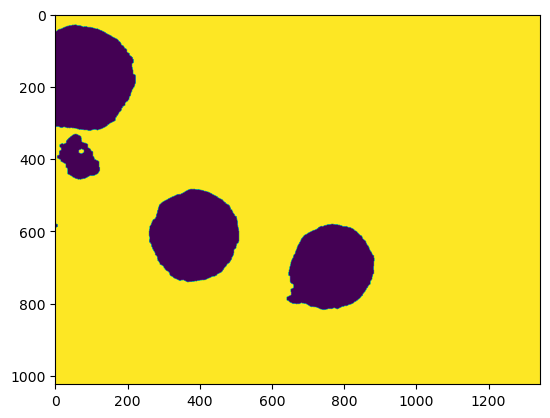

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imreadmulti("data/DG4.5.tif")[1][0]

size_per_pixel = 0.6449999809265137
# Process the image to remove background
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=3)
plt.imshow(closing)

Get contours and filter

In [4]:
# Use a mask to get only the objects
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Skip contours that are touching the edges of the image
# Get image dimensions
height, width = closing.shape[:2]

# Initialize list to store contours that are not touching the edges
filtered_contours = []

# Loop through all contours
for i, cnt in enumerate(contours):
    # Check if any coordinate of the contour is touching the edges of the image
    if any((coord[0][0] == 0 or coord[0][0] == width-1 or coord[0][1] == 0 or coord[0][1] == height-1) for coord in cnt):
        continue  # Skip contour if touching edges
    # Check if contour is inside another contour
    filtered_contours.append(cnt)  # Add contour to filtered list if not touching edges

# Function to check if a contour is a subset of another contour
def is_contour_subset(cnt, other_cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    other_x, other_y, other_w, other_h = cv2.boundingRect(other_cnt)
    if x >= other_x and y >= other_y and x+w <= other_x+other_w and y+h <= other_y+other_h:
        return True
    else:
        return False

contours = filtered_contours
filtered_contours = []

# Loop through all contours
for i, cnt in enumerate(contours):
    # Check if cnt is a subset of any other contour
    is_subset = False
    for j, other_cnt in enumerate(contours):
        if i != j and is_contour_subset(cnt, other_cnt):
            is_subset = True
            break
    # If cnt is not a subset, add it to the filtered_contours list
    if not is_subset:
        filtered_contours.append(cnt)

Get diameters

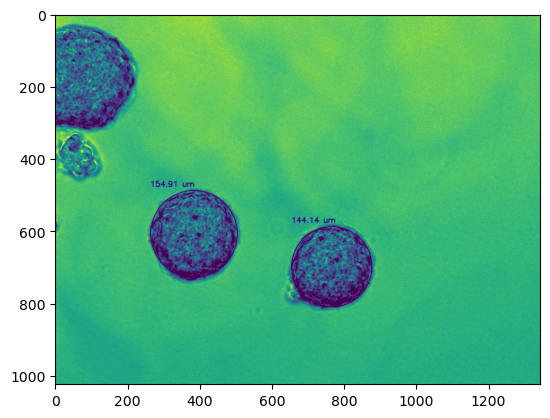

In [5]:
def get_best_fit_circle(contour):
    # Create a binary image from the contour
    x_size, y_size = image.shape
    img = np.zeros((x_size, y_size), np.uint8)
    cv2.drawContours(img, [contour], 0, 255, -1)

    # Calculate the distance transform
    dist_transform = cv2.distanceTransform(img, cv2.DIST_L2, 3)

    # Find the maximum distance and its corresponding pixel
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(dist_transform)

    # Draw the maximum inscribed circle
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.circle(img, max_loc, int(max_val), (0, 255, 0), 2)

    # Display the image
    plt.imshow(img)
    return max_loc, max_val

# Measure the maximum diameter of each circular object that is not touching the edges of the image
diameters = []
# Draw the diameters on the image
result = image.copy()
for cnt in filtered_contours:
    if cv2.contourArea(cnt) > 100:
        # Get the smallest enclosing circle using the MED algorithm
        (x,y), radius = get_best_fit_circle(cnt)

        diameter = radius * 2 * size_per_pixel
        if diameter < 100:
            continue

        center = (int(x), int(y))
        # Draw circle
        cv2.circle(result, center, int(radius), (0, 255, 0), 2)
        cv2.putText(result, f'{diameter:.2f} um', (int(x-radius),int(y-radius)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        diameters.append(diameter)


# Display the original image with the diameters drawn
plt.imshow(result)

Looks good for some images, but not for others :(
- Ex: number 7

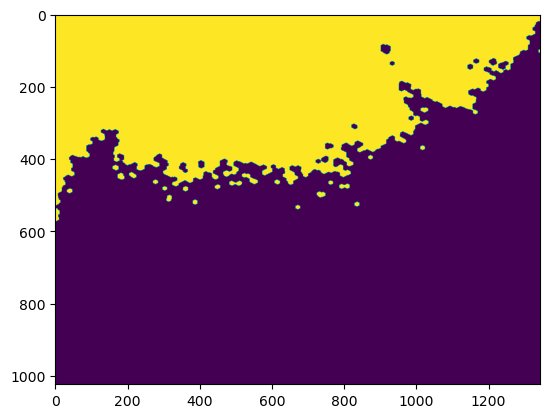

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imreadmulti("data/DG4.5.tif")[1][7]

size_per_pixel = 0.6449999809265137
# Process the image to remove background
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=3)
plt.imshow(closing)

## V2
Previous version was not working well to get rid of background for some images.
Use structured forest ML to get rid of background and do analysis

Get rid of background

In [40]:
# wget https://github.com/opencv/opencv_extra/raw/master/testdata/cv/ximgproc/model.yml.gz -O model.yml.gz
# gzip -d model.yml.gz

size_per_pixel = 0.6449999809265137

# Read TIFF stack
image = cv2.imreadmulti("data/DG4.5.tif")[1][13]

# Convert the input image to the correct format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.float32(image) / 255.0

# Perform edge detection using a structured forest ML model
edge_detector = cv2.ximgproc.createStructuredEdgeDetection("model.yml")
edges = edge_detector.detectEdges(image)
edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

def filterOutSaltPepperNoise(edgeImg):
    # Get rid of salt & pepper noise.
    count = 0
    lastMedian = edgeImg
    median = cv2.medianBlur(edgeImg, 3)
    while not np.array_equal(lastMedian, median):
        # get those pixels that gets zeroed out
        zeroed = np.invert(np.logical_and(median, edgeImg))
        edgeImg[zeroed] = 0

        count = count + 1
        if count > 50:
            break
        lastMedian = median
        median = cv2.medianBlur(edgeImg, 3)


edges_8u = np.asarray(edges, np.uint8)
filterOutSaltPepperNoise(edges_8u)

# Get an approximate contour of the object
contours, hierarchy = cv2.findContours(edges_8u, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Get contours and filter

In [41]:
# Skip contours that are touching the edges of the image
# Get image dimensions
height, width = image.shape[:2]

# Initialize list to store contours that are not touching the edges
filtered_contours = []

# Loop through all contours
for i, cnt in enumerate(contours):
    # Check if any coordinate of the contour is touching the edges of the image
    if any((coord[0][0] == 0 or coord[0][0] == width-1 or coord[0][1] == 0 or coord[0][1] == height-1) for coord in cnt):
        continue  # Skip contour if touching edges
    # Check if contour is inside another contour
    filtered_contours.append(cnt)  # Add contour to filtered list if not touching edges

# Function to check if a contour is a subset of another contour
def is_contour_subset(cnt, other_cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    other_x, other_y, other_w, other_h = cv2.boundingRect(other_cnt)
    if x >= other_x and y >= other_y and x+w <= other_x+other_w and y+h <= other_y+other_h:
        return True
    else:
        return False

contours = filtered_contours
filtered_contours = []

# Loop through all contours
for i, cnt in enumerate(contours):
    # Check if cnt is a subset of any other contour
    is_subset = False
    for j, other_cnt in enumerate(contours):
        if i != j and is_contour_subset(cnt, other_cnt):
            is_subset = True
            break
    # If cnt is not a subset, add it to the filtered_contours list
    if not is_subset:
        filtered_contours.append(cnt)

len(filtered_contours), len(contours)

(15, 52)

Get diameters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x: 572, y: 272, radius: 84.48188781738281


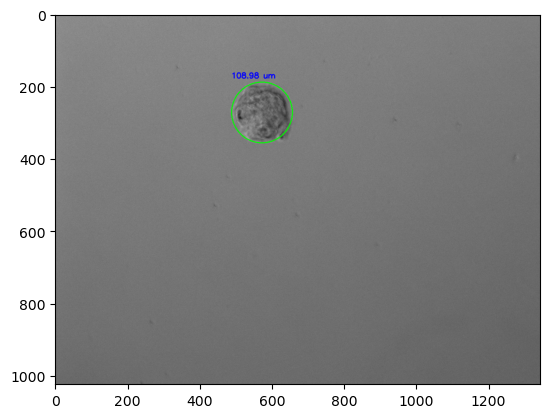

In [42]:
def get_best_fit_circle(contour):
    # Create a binary image from the contour
    x_size, y_size, _ = image.shape
    img = np.zeros((x_size, y_size), np.uint8)
    # Turn the contour into a convex hull
    contour = cv2.convexHull(contour)
    cv2.drawContours(img, [contour], 0, 255, -1)

    # Calculate the distance transform
    dist_transform = cv2.distanceTransform(img, cv2.DIST_L2, 3)

    # Find the maximum distance and its corresponding pixel
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(dist_transform)

    # Draw the maximum inscribed circle
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.circle(img, max_loc, int(max_val), (0, 255, 0), 2)

    # Display the image
    plt.imshow(img)
    return max_loc, max_val

# Measure the maximum diameter of each circular object that is not touching the edges of the image
diameters = []
# Draw the diameters on the image
result = image.copy()
for cnt in filtered_contours:
    if cv2.contourArea(cnt) > 100:
        # Get the smallest enclosing circle using the MED algorithm
        (x,y), radius = get_best_fit_circle(cnt)
        print(f'x: {x}, y: {y}, radius: {radius}')
        # Show the image
        diameter = radius * 2 * size_per_pixel
        if diameter < 100:
            continue
        center = (int(x), int(y))
        # Draw circle
        cv2.circle(result, center, int(radius), (0, 255, 0), 2)
        cv2.putText(result, f'{diameter:.2f} um', (int(x-radius),int(y-radius)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        diameters.append(diameter)

# Display the original image with the diameters drawn
plt.imshow(result)

Pipeline going through stack

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


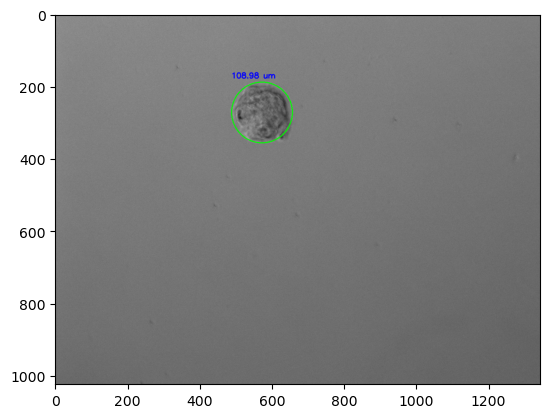

In [43]:
size_per_pixel = 0.6449999809265137

# Read TIFF stack
image = cv2.imreadmulti("data/DG4.5.tif")[1][13]
def get_edges(image):
    # Convert the input image to the correct format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.float32(image) / 255.0

    # Perform edge detection using a structured forest ML model
    edge_detector = cv2.ximgproc.createStructuredEdgeDetection("model.yml")
    edges = edge_detector.detectEdges(image)
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

    def filterOutSaltPepperNoise(edgeImg):
        # Get rid of salt & pepper noise.
        count = 0
        lastMedian = edgeImg
        median = cv2.medianBlur(edgeImg, 3)
        while not np.array_equal(lastMedian, median):
            # get those pixels that gets zeroed out
            zeroed = np.invert(np.logical_and(median, edgeImg))
            edgeImg[zeroed] = 0

            count = count + 1
            if count > 50:
                break
            lastMedian = median
            median = cv2.medianBlur(edgeImg, 3)


    edges_8u = np.asarray(edges, np.uint8)
    filterOutSaltPepperNoise(edges_8u)
    return edges_8u, image

def filtered_contours(edges, image):
    # Get an approximate contour of the object
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Skip contours that are touching the edges of the image
    # Get image dimensions
    height, width = image.shape[:2]

    # Initialize list to store contours that are not touching the edges
    filtered_contours = []

    # Loop through all contours
    for i, cnt in enumerate(contours):
        # Check if any coordinate of the contour is touching the edges of the image
        if any((coord[0][0] == 0 or coord[0][0] == width-1 or coord[0][1] == 0 or coord[0][1] == height-1) for coord in cnt):
            continue  # Skip contour if touching edges
        # Check if contour is inside another contour
        filtered_contours.append(cnt)  # Add contour to filtered list if not touching edges

    # Function to check if a contour is a subset of another contour
    def is_contour_subset(cnt, other_cnt):
        x, y, w, h = cv2.boundingRect(cnt)
        other_x, other_y, other_w, other_h = cv2.boundingRect(other_cnt)
        if x >= other_x and y >= other_y and x+w <= other_x+other_w and y+h <= other_y+other_h:
            return True
        else:
            return False

    contours = filtered_contours
    filtered_contours = []

    # Loop through all contours
    for i, cnt in enumerate(contours):
        # Check if cnt is a subset of any other contour
        is_subset = False
        for j, other_cnt in enumerate(contours):
            if i != j and is_contour_subset(cnt, other_cnt):
                is_subset = True
                break
        # If cnt is not a subset, add it to the filtered_contours list
        if not is_subset:
            filtered_contours.append(cnt)
    return filtered_contours

def get_diameters(filtered_contours, image):
    def get_best_fit_circle(contour):
        # Create a binary image from the contour
        x_size, y_size, _ = image.shape
        img = np.zeros((x_size, y_size), np.uint8)
        # Turn the contour into a convex hull
        contour = cv2.convexHull(contour)
        cv2.drawContours(img, [contour], 0, 255, -1)
        # Calculate the distance transform
        dist_transform = cv2.distanceTransform(img, cv2.DIST_L2, 3)

        # Find the maximum distance and its corresponding pixel
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(dist_transform)

        # Draw the maximum inscribed circle
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.circle(img, max_loc, int(max_val), (0, 255, 0), 2)

        return max_loc, max_val

    # Measure the maximum diameter of each circular object that is not touching the edges of the image
    diameters = []
    # Draw the diameters on the image
    result = image.copy()
    for cnt in filtered_contours:
        if cv2.contourArea(cnt) > 100:
            # Get the smallest enclosing circle using the MED algorithm
            (x,y), radius = get_best_fit_circle(cnt)

            diameter = radius * 2 * size_per_pixel
            if diameter < 100:
                continue

            center = (int(x), int(y))
            # Draw circle
            cv2.circle(result, center, int(radius), (0, 255, 0), 2)
            cv2.putText(result, f'{diameter:.2f} um', (int(x-radius),int(y-radius)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            diameters.append(diameter)
    return diameters, result


edges, image = get_edges(image)
filtered_cntrs = filtered_contours(edges, image)
diameters, result = get_diameters(filtered_cntrs, image)
# Display the original image with the diameters drawn
plt.imshow(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

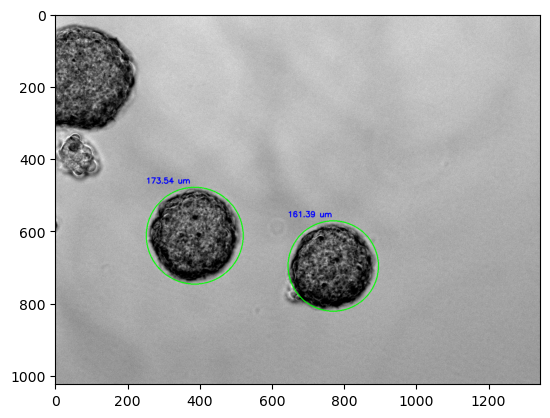

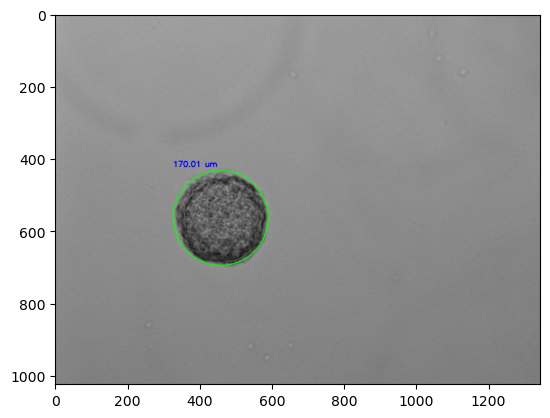

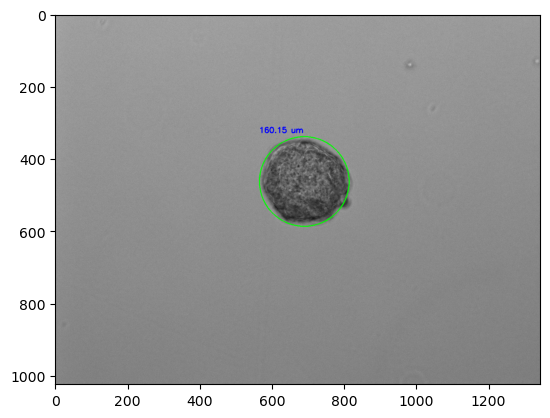

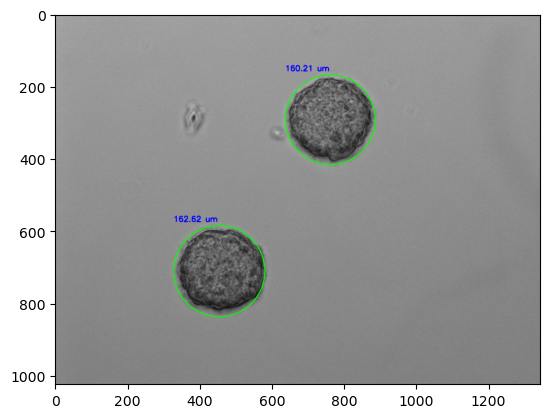

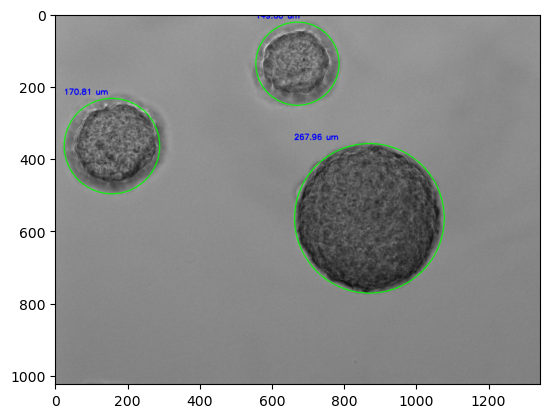

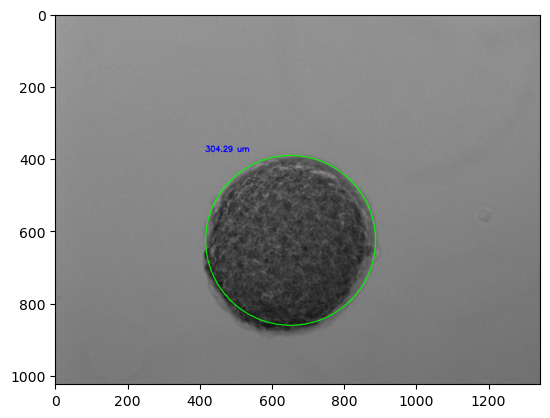

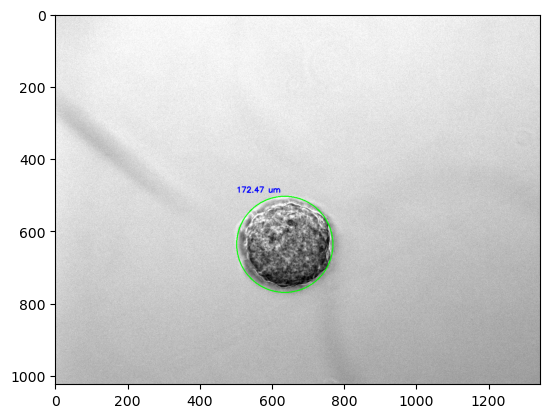

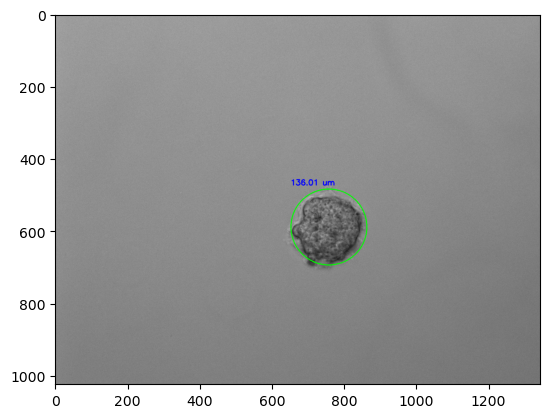

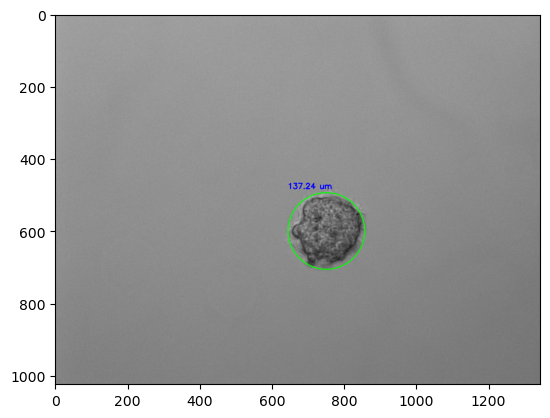

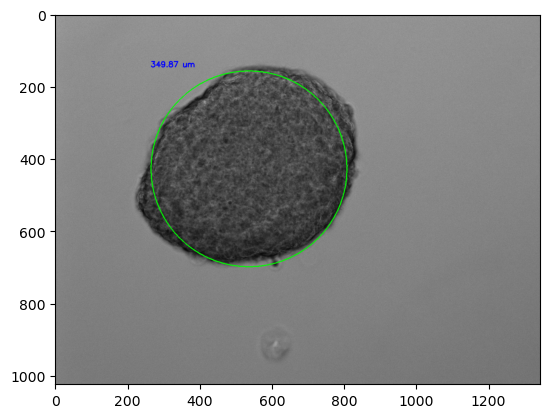

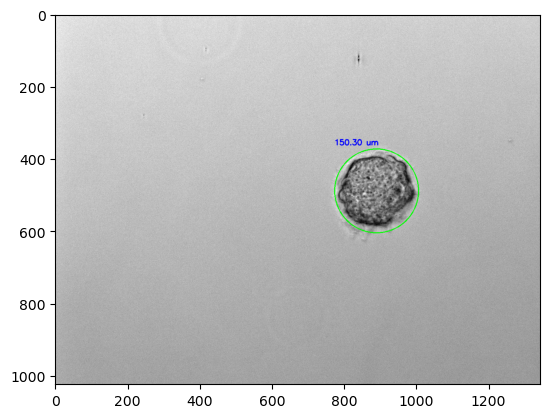

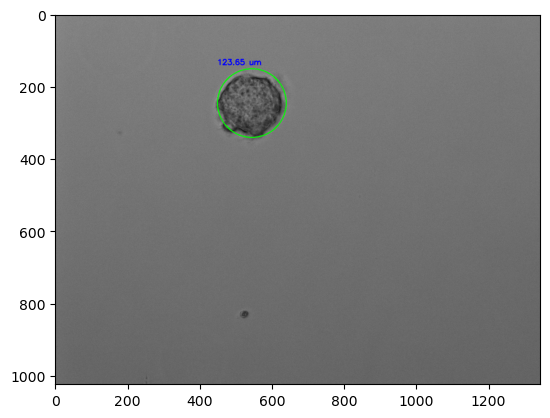

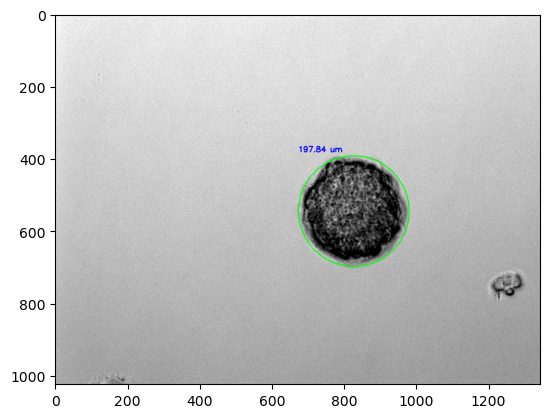

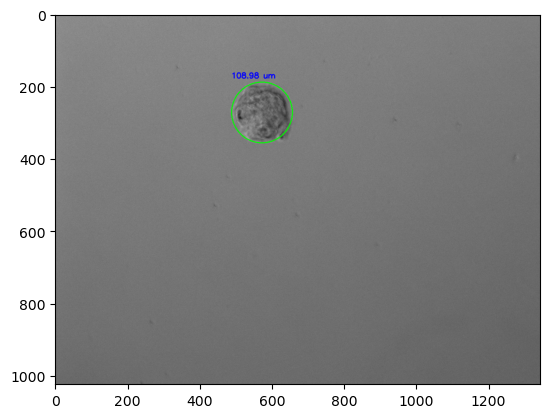

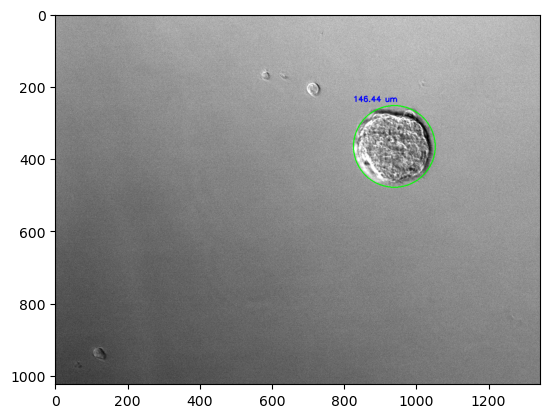

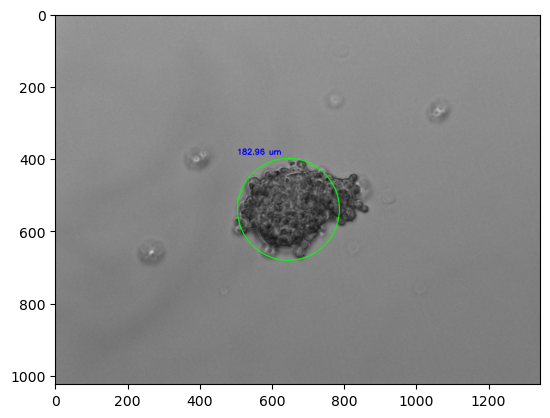

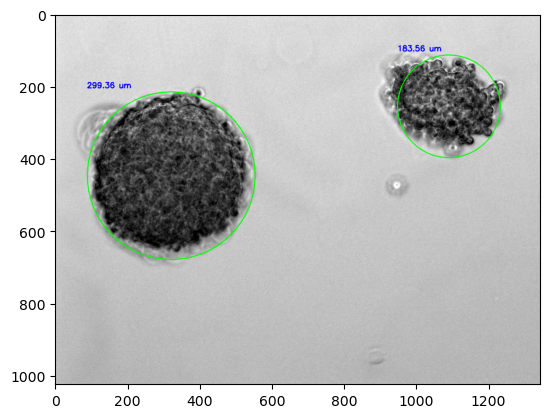

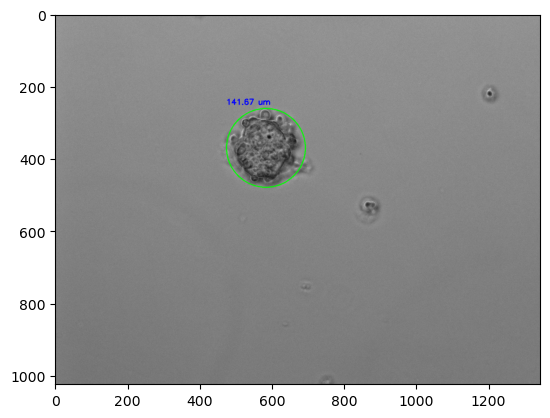

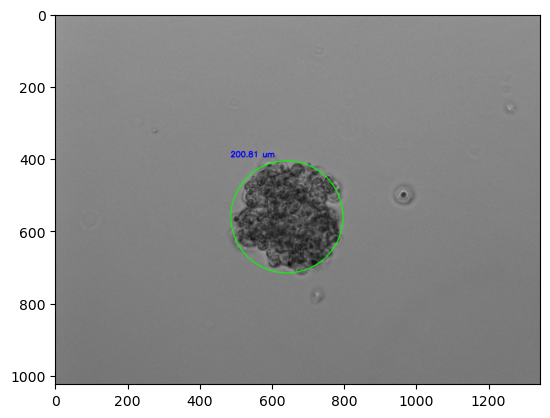

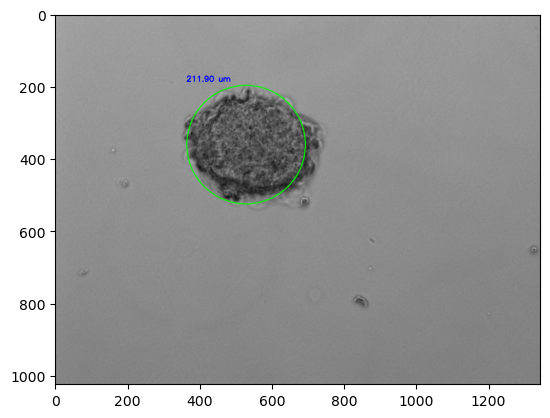

<Figure size 640x480 with 0 Axes>

In [44]:
images = cv2.imreadmulti("data/DG4.5.tif")[1]
diameters = []
for image in images:
    edges, image = get_edges(image)
    filtered_cntrs = filtered_contours(edges, image)
    diameter, result = get_diameters(filtered_cntrs, image)
    diameters.append(diameter)
    plt.imshow(result)
    plt.figure()

In [45]:
diameters

[[161.38575465754548, 173.54219732174533],
 [170.0094209369563],
 [160.15380233191536],
 [162.6177069831756, 160.2068896411365],
 [267.95656937720196, 170.8052187955036, 149.6006672680087],
 [304.2922244306392],
 [172.47332558821654],
 [136.0118908143777],
 [137.2438431400078],
 [349.87446047895355],
 [150.2981837268744],
 [123.64717346761608],
 [197.83547754818574],
 [108.98163206169556],
 [146.43924615788274],
 [182.96166145970346],
 [299.3644151281187, 183.5608965188876],
 [141.6745174474636],
 [200.80822907770926],
 [211.89580000838032]]

## Analysis of diameters

ImageJ macro to get the labels for each image
```ImageJ
// Get the names of each image in the stack
names = newArray(nSlices);

for (i = 1; i <= nSlices; i++) {
    setSlice(i);
    names[i-1] = getInfo("slice.label");

}

Array.print(names);
```

In [54]:
import pandas as pd
labels = ["DG4.5.sld - 50.1", "DG4.5.sld - 50.2", "DG4.5.sld - 50.3", "DG4.5.sld - 50.4", "DG4.5.sld - 50.5", "DG4.5.sld - 50.6", "DG4.5.sld - 50.7", "DG4.5.sld - 100.1", "DG4.5.sld - 100.2", "DG4.5.sld - 100.3", "DG4.5.sld - 100.4", "DG4.5.sld - 100.5", "DG4.5.sld - 100.6", "DG4.5.sld - 100.7", "DG4.5.sld - 100.8", "DG4.5.sld - 150.1", "DG4.5.sld - 150.2", "DG4.5.sld - 150.3", "DG4.5.sld - 150.4", "DG4.5.sld - 150.5"]
# Combine diameters and labels into a dataframe
df = pd.DataFrame({'diameter': diameters, 'label': labels})
# Get rid of DG4.5.sld of each string in the label column
df['label'] = df['label'].str.replace('DG4.5.sld - ', '')
# Make a new df where you groupby the number before the decimal point in the label column
# Concatenate the diameters in each group into a new list
df = df.groupby(df['label'].str.split('.').str[0]).agg({'diameter': lambda x: list(x)})
# Flatten the list of diameters
df['diameter'] = df['diameter'].apply(lambda x: [item for sublist in x for item in sublist])

/var/folders/9m/qcg58ft12w72z4h1j7s196w00000gn/T/ipykernel_53024/2271318543.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace('DG4.5.sld - ', '')


diameter
label                                                   
100    [136.0118908143777, 137.2438431400078, 349.874...
150    [182.96166145970346, 299.3644151281187, 183.56...
50     [161.38575465754548, 173.54219732174533, 170.0...

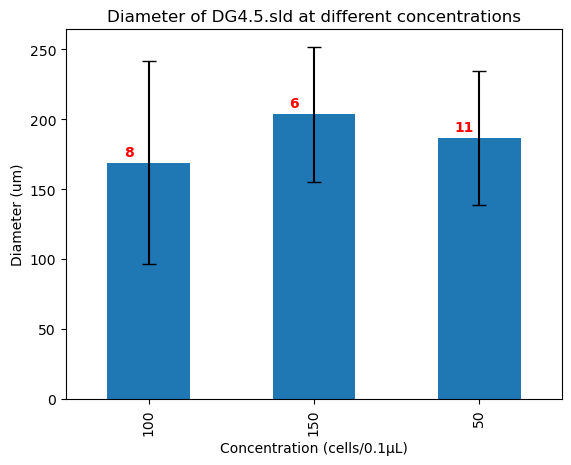

In [63]:
# Plot the mean diameter of each group
df['mean'] = df['diameter'].apply(lambda x: np.mean(x))
df['std'] = df['diameter'].apply(lambda x: np.std(x))
df['mean'].plot(kind='bar', yerr=df['std'], capsize=5)
plt.ylabel('Diameter (µm)')
plt.xlabel('Concentration (cells/0.1µL)')
plt.title('Diameter of DG4.5.sld at different concentrations')
# Include the number of measurements for each group
for i, v in enumerate(df['mean']):
    plt.text(i-0.15, v+5, str(len(df['diameter'][i])), color='red', fontweight='bold')

- 5000 cells
- Diameter of 175 µm